In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt


SEED = 42 # Use same seed for replicable data generation
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Import data loader and loss function
from FNO1D_utils import (
    data_loader,
    relative_min_max,
    normal_RMSE,
)
# Set path to data set
path = '/mimer/NOBACKUP/groups/ml_flame_storage/Max_1D/Data/1D5000.h5'
from FNO1D import FNO1d

train_loader, test_loader, * _ = data_loader(path, batch_size=100)

Epoch [1/1200] - Train Loss: 2.753608 - Test Loss: 0.811334 - Test Relative Error: 27.044479%
  Train:  Temperature Rel: 126.569221% | Pressure Rel: 103.949121% | Velocity Rel: 44.842450% | 
  Test:   Temperature Rel: 28.264981% | Pressure Rel: 26.891378% | Velocity Rel: 25.977075% | 

Epoch [51/1200] - Train Loss: 0.398505 - Test Loss: 0.309781 - Test Relative Error: 10.326019%
  Train:  Temperature Rel: 19.368268% | Pressure Rel: 10.918881% | Velocity Rel: 9.563368% | 
  Test:   Temperature Rel: 16.305812% | Pressure Rel: 7.650606% | Velocity Rel: 7.021637% | 

Epoch [101/1200] - Train Loss: 0.293539 - Test Loss: 0.247357 - Test Relative Error: 8.245239%
  Train:  Temperature Rel: 12.961126% | Pressure Rel: 8.410060% | Velocity Rel: 7.982696% | 
  Test:   Temperature Rel: 12.433595% | Pressure Rel: 6.196342% | Velocity Rel: 6.105779% | 

Epoch [151/1200] - Train Loss: 0.252278 - Test Loss: 0.211866 - Test Relative Error: 7.062198%
  Train:  Temperature Rel: 11.488145% | Pressure Rel:

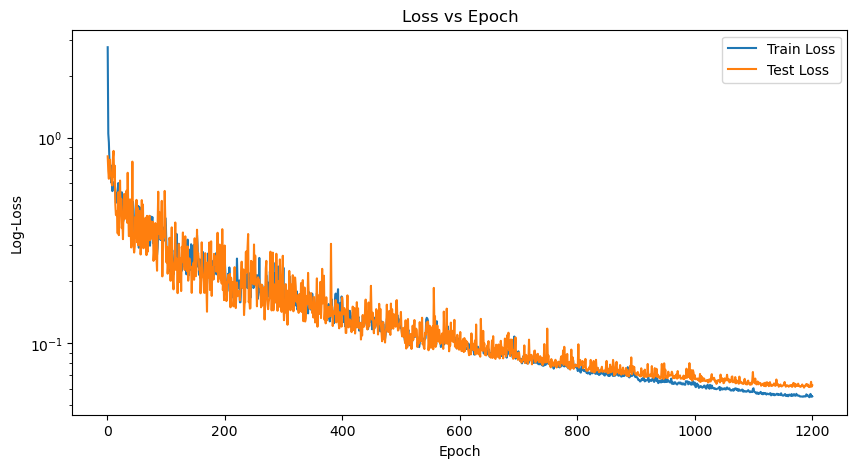

In [5]:

# --------------------------------------------------------------------------------
# 5) Training 
# --------------------------------------------------------------------------------
if __name__ == "__main__":
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # ------------------------------------------------
    # Instantiate the FNO and training parameters
    # ------------------------------------------------
    model = FNO1d(modes=16, width=32, hidden_mlp=128, N_x=128, N_fourier_layers=4).to(device)
    epochs = 1200
    learning_rate = 1e-2
    step_size = 100
    gamma = 0.7
    weight_decay = 1e-4
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    
    # Define loss and error evaluation function
    criterion_loss = relative_min_max
    criterion_eval = relative_min_max
   
    
    # ------------------------------------------------
    # Preallocate losses and relative errors
    # ------------------------------------------------
    train_losses = []
    test_losses = []
    test_rel_list = []
    test_rel_pressure_list = []
    test_rel_velocity_list = []
    test_rel_temperature_list = []
    rel_final_batch = []
    rel_err_sum = 0
    
    # ------------------------------------------------
    # Training loop
    # ------------------------------------------------
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0.0
        train_rel_pressure = 0.0
        train_rel_velocity = 0.0
        train_rel_temperature = 0.0
        for bc, target_field, x, y in train_loader:
            bc, target_field, x, y = bc.to(device), target_field.to(device), x.to(device), y.to(device)
            optimizer.zero_grad()
            pred_field = model(bc, x, y)

            # Training loss
            loss_vec = criterion_loss(pred_field, target_field)
            loss = (loss_vec[0] + loss_vec[1] + loss_vec[2])
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

            # Batch wise relative errors
            train_eval_error = criterion_eval(pred_field, target_field)*100
            batch_train_rel_temperature = train_eval_error[0]
            batch_train_rel_pressure = train_eval_error[1]
            batch_train_rel_velocity = train_eval_error[2]
            train_rel_pressure += batch_train_rel_pressure.item()
            train_rel_velocity += batch_train_rel_velocity.item()
            train_rel_temperature += batch_train_rel_temperature.item()
            
        # Average over batchwise losses and errors    
        avg_train_loss = total_train_loss / len(train_loader)
        avg_train_rel_pressure = train_rel_pressure / len(train_loader)
        avg_train_rel_velocity = train_rel_velocity / len(train_loader)
        avg_train_rel_temperature = train_rel_temperature / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # ------------------------------------------------
        # Evaluate model on test data
        # ------------------------------------------------
        model.eval()
        total_test_loss = 0.0
        test_rel_error = 0.0
        test_rel_pressure = 0.0
        test_rel_velocity = 0.0
        test_rel_temperature = 0.0
        with torch.no_grad():
            for bc, target_field, x, y in test_loader:
                bc, target_field, x, y = bc.to(device), target_field.to(device), x.to(device), y.to(device)
                pred_field = model(bc, x, y)

                # Test Loss
                loss_vec = criterion_eval(pred_field, target_field)
                loss = (loss_vec[0] + loss_vec[1] + loss_vec[2])
                total_test_loss += loss.item()

                batch_rel_error = torch.mean(loss_vec)*100
                test_rel_error += batch_rel_error.item()

                # Batch wise relative errors
                test_eval_error = criterion_eval(pred_field, target_field)*100
                batch_rel_temperature = test_eval_error[0]
                batch_rel_pressure = test_eval_error[1]
                batch_rel_velocity = test_eval_error[2]

                test_rel_temperature += batch_rel_temperature.item()
                test_rel_pressure += batch_rel_pressure.item()
                test_rel_velocity += batch_rel_velocity.item()
                
                # Individual relative error of each sample
                if epoch == epochs-1:
                    num = (pred_field-target_field)**2
                    denom = (torch.amax(target_field, dim=[1], keepdim=True) - torch.amin(target_field, dim=[1], keepdim=True))**2
                    rel_err = torch.mean(num/denom, dim=[1])
                    rel_err = torch.sqrt(rel_err)*100
                    rel_final_batch.extend(rel_err.cpu().tolist())


        # Average batchwise errors
        avg_test_loss = total_test_loss / len(test_loader)
        avg_test_rel = test_rel_error / len(test_loader)
        avg_rel_pressure = test_rel_pressure / len(test_loader)
        avg_rel_velocity = test_rel_velocity / len(test_loader)
        avg_rel_temperature = test_rel_temperature / len(test_loader)
        test_losses.append(avg_test_loss)

        # Store test relative errors for plotting
        test_rel_list.append(avg_test_rel)
        test_rel_temperature_list.append(avg_rel_temperature)
        test_rel_pressure_list.append(avg_rel_pressure)
        test_rel_velocity_list.append(avg_rel_velocity)
        
        if epoch % 50 == 0 or epoch == epochs - 1:
            print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {avg_train_loss:.6f} - Test Loss: {avg_test_loss:.6f} - Test Relative Error: {avg_test_rel:.6f}%")
            print(
                f"  Train:  Temperature Rel: {avg_train_rel_temperature:.6f}% | "
                f"Pressure Rel: {avg_train_rel_pressure:.6f}% | "
                f"Velocity Rel: {avg_train_rel_velocity:.6f}% | "
                
            )
            print(
                f"  Test:   Temperature Rel: {avg_rel_temperature:.6f}% | "
                f"Pressure Rel: {avg_rel_pressure:.6f}% | "
                f"Velocity Rel: {avg_rel_velocity:.6f}% | "
                
            )
            print()
        scheduler.step()
        
    print("Training complete!")
    # ------------------------------------------------
    # Plot losses vs Epoch
    # ------------------------------------------------
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs+1), train_losses, label="Train Loss")
    plt.plot(range(1, epochs+1), test_losses, label="Test Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Log-Loss")
    plt.yscale('log')
    plt.title("Loss vs Epoch")
    plt.legend()
    plt.show()

In [ ]:
torch.save(model.state_dict(), '1D5000Model.pth')